# Language Knowledge (Vocabulary)
Duration: 30 minutes
Content: This section tests your knowledge of Japanese vocabulary, including kanji readings, orthography, word formation, contextually-defined expressions, paraphrases, and usage
It mainly composes following five categories:
- ``Reading Kana`` (Pronunciation Questions): Given a kanji word, choose the correct kana reading.
- `Writing Kanji` (Writing Questions): Given a word written in kana, choose the correct kanji representation.
- `Word Meaning` Selection (Vocabulary Understanding): Choose the most suitable word to fill in the sentence from four options.
- `Synonym Replacement`: Select a word that has the same or similar meaning as the underlined word.
- `Vocabulary Usage`: Assess the usage of words in actual contexts, choosing the most appropriate word usage, including some common Japanese expressions or fixed phrases.

In [212]:
import pandas as pd
import json
import os
import random
import pickle
import re
import uuid
from typing import *
from langchain_openai import AzureOpenAI,AzureChatOpenAI
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from dotenv import load_dotenv
from langchain_aws import ChatBedrock
from langchain.embeddings.base import Embeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.embeddings import HuggingFaceEmbeddings
# from langchain_community.embeddings import XinferenceEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from IPython.display import display, Markdown, Latex
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage,RemoveMessage,HumanMessage,AIMessage,ToolMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field, validator
from typing import List, Optional
from langchain_tavily import TavilySearch
from langchain.schema import Document
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
load_dotenv()

True

In [213]:
azure_llm = AzureChatOpenAI(
    azure_endpoint="https://ai-rolandaws880125ai409947751408.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2025-01-01-preview",
    api_key=os.environ["AZURE_API_KEY"],
    model_name="gpt-4o",
    api_version="2025-01-01-preview",
    temperature=0.5,
)

aws_llm = ChatBedrock(
    # model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
     model_id="us.anthropic.claude-3-5-haiku-20241022-v1:0",
    model_kwargs=dict(temperature=0.5),
    region = "us-east-2",
    aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
    aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
)

In [214]:
# Import N3 Vocabulary
file_path = '../Vocab/n3.csv'
# Read the CSV file
data = pd.read_csv(file_path)
words = data.iloc[:, :2].sample(frac=1).reset_index(drop=True)
# Display the content of the CSV file
words.head()
vocab_dict = words.set_index(words.columns[0])[words.columns[1]].to_dict()
vocab_dict = json.dumps(vocab_dict, ensure_ascii=False, separators=(',', ':'))

#### load Models

#### Exam Paper Outline
### A. overall thinking the structure of an exam
1. distribution of the difficulty 
2. topics
3. reasoning

## Data Strcuture

# Kanji 读假名（读音问题）

In [215]:
def online_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    
    print("---WEB SEARCH---")
    
    topic = state['messages'][0].content
    
    tavily_search_tool = TavilySearch(
        max_results=5,
        topic="news",
        days=1
    )
    # Web search
    docs = tavily_search_tool.invoke({"query": topic})
    
    print(docs)

    web_results = "\n".join([d["content"] for d in docs["results"]])
    
    print("Web results: ", web_results)

    return {"documents": web_results, "topic": topic}

In [216]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


class SimpleChoiceQuestionOutput(TypedDict):
    """Question Formatted Output"""
    question: Annotated[str, "the question to ask candidate"]
    explanation: Annotated[str, "the key challenges and explanation in Chinese"]
    correct_answer: Annotated[int, "correct option"]
    choices: Annotated[List, "options as a list for candidate to choose"]

# Graph stater
class QuestionState(TypedDict):
    topic: str
    question: str
    documents: str
    formatted_output: SimpleChoiceQuestionOutput
    messages: Annotated[list, add_messages]


example = """
1. 山田さんがちらしを **配った**。  
　1 ひろった　2 くばった　3 やぶった　4 はった

2. 私の国は **石油** を輸入しています。  
　1 いしゅ　2 せきそう　3 せきゆ　4 いしう

3. 卒業式には住徒の **父母** たちもたくさん来ていた。  
　1 ふば　2 ふぼ　3 ふうぼ　4 ちちば

4. この町の主要な産業は何ですか。  
　1 じゅちょう　2 しゅおう　3 じゅよう　4 しゅよう

5. これは **加熱** して食べてください。  
　1 かわつ　2 かねつ　3 かいねつ　4 かいあつ

6. 川はあの **辺り** で **深く** なっている。  
　1 ふかく　2 あさく　3 ひろく　4 せまく

7. 失礼なことを言われたので、つい **感情的** になってしまった。  
　1 がんじょうてき　2 かんじょうてき　3 かんしょうてき　4 がんしょうてき

8. これは **残さない** でください。  
　1 なさないで　2 よこさないで　3 ごぼさないで　4 のこさないで
"""

# Nodes
def question_draft_generator(state: QuestionState):
    """First LLM call to generate initial question"""
    print("---Generator----")
        
    search_result = state['documents'],
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """
    Role: You are a Japanese Teacher
    Task: Write a kanji question for the JLPT N3 exam. Your job is to provide a kanji vocabulary word in a short sentence and ask the candidate to choose the correct kana reading. 
    
    Instructions:
    Format: Follow the format of the Formal exam paper. Please don't describe the task in the question.
    Content: Ensure the vocabulary is restricted to N3 level. Use the vocabulary in the `Dictionary` as much as possible.
    Reference: Get inspiration from the Search result. Only use the format as a reference; do not use any specific content from existing exams.
    Explanation: Append the correct answer and an explanation of the main challenges  at each question.
                Finally, output beautiful markdown format.
                    Dictionary: {vocab_dict}
                    Search result: {search_result}
                    Formal exam paper: {example}
                """
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    
    input = { "topic" : state['topic'],
              "search_result": search_result, 
              "vocab_dict": vocab_dict,
              "example": example,
              "messages": state["messages"]
              }
    # final_message = prompt.format_messages(**input)
    # print(final_message)
    
    generate = prompt | azure_llm
    
    msg = generate.invoke(input=input)
    
    
    return {"question": msg.content, "messages": [AIMessage(content=msg.content)] }


def reflection_node(state: QuestionState) -> QuestionState:
    print("---REVISOR---")
    
    # Other messages we need to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    # First message is the original user request. We hold it the same for all nodes
    translated = [state["messages"][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state["messages"][1:]
    ]

    reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """you are a Japanese language educator reviewing a JLPT exam paper. Generate critique and recommendations for the user's submission.
            the review focuses on content accuracy and question quality. 
            - For content accuracy, you must verify that the grammar and vocabulary questions accurately reflect the appropriate JLPT N3 level, ensuring the reading passages are clear, relevant, and appropriately challenging. 
            - For question quality, you must ensure all questions are clearly worded and free from ambiguity to comprehensively assess different language skills, and confirm that the difficulty level of the questions matches the intended JLPT N3 level.
            - During detailed refinement, you check the format and presentation of the paper, ensuring it is well-organized and the instructions are clear and concise. you also ensure the content is culturally appropriate and relevant to Japanese language and culture.
            - Finally, you make give feedback, providing detailed recommendations, including requests.If you think the exam paper is good enough, you just say "GOOD ENOUGH"
            """
        ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    reflect = reflection_prompt | azure_llm
    
    res = reflect.invoke(translated)
    
    print(res.content)
    
    # We treat the output of this as human feedback for the generator
    return {"messages": [HumanMessage(content=res.content)]}


def formatter_node(state: QuestionState) -> QuestionState:
    print("--- Formatter ---")
    
    question = state["question"]
    
    print("### I am going to format: ",question)
    
    formatter_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a AI assistance. your job is to format the following content to the structured output, please don't modify contextual meanings and keep markdown format. Also, don't repeat question in the output. If explanation section is in japanese, please translate to simplified chinese:
            {question}
            """
        )
        ]
    )
    format_pipeline = formatter_prompt | azure_llm.with_structured_output(SimpleChoiceQuestionOutput)
    res = format_pipeline.invoke(input={"question": question})
    
    # We treat the output of this as human feedback for the generator
    return {"formatted_output": res }



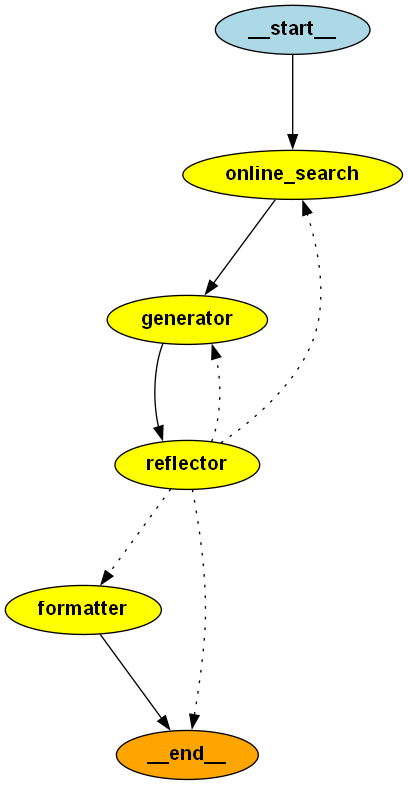

In [217]:
# Build workflow
builder = StateGraph(QuestionState)

builder.add_node("online_search", online_search)
builder.add_node("generator", question_draft_generator)
builder.add_node("reflector", reflection_node)
builder.add_node("formatter",formatter_node)
# Add nodes

def should_continue(state: QuestionState):
    if state["messages"]:
        if len(state["messages"]) > 6: 
            print("--- Reach the Maximum Round ---")
            return "formatter"
        elif "GOOD ENOUGH" in state["messages"][-1].content:
            print("--- AI Reviser feels Good Enough ---")
            return "formatter"
    return "generator"

# Add edges to connect nodes
builder.add_edge(START, "online_search")
builder.add_edge("online_search", "generator")
builder.add_edge("generator", "reflector")
# 
builder.add_conditional_edges("reflector", should_continue)
builder.add_edge("formatter",END)
memory = MemorySaver()

# Compile
kanji_graph = builder.compile()

# Show workflow
display(Image(kanji_graph.get_graph().draw_png()))

In [218]:
row = words.iloc[1]
word = f"{row[0]}({row[1]})"
word

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20260\878816679.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  word = f"{row[0]}({row[1]})"


'個々(ここ)'

In [219]:
# # Debug the Conversation
# for event in kanji_graph.stream(
#     {
#         "messages": [
#             HumanMessage(
#                 content=word
#             )
#         ],
#     },
#     config={"configurable": {"thread_id": "1"}},
# ):
#     print(event)
#     print("---")

In [220]:
kanji = kanji_graph.invoke(
    {
       "messages": [
                HumanMessage(
                    content=word
                )
            ],
        },
    config={"configurable": {"thread_id": "1"}}
)
display(Markdown(kanji["question"]))

---WEB SEARCH---
{'query': '個々(ここ)', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': '「個々」と「個別」の違いとは？分かりやすく解釈 | 意味解説辞典', 'url': 'https://meaning-dictionary.com/「個々」と「個別」の違いとは？分かりやすく解/', 'content': '「個々」とは? 「個々(ここ)」 とは、 「物がいくつかある内の一つ一つ」 や 「人が複数いる場合の一人一人」 を意味している言葉です。 「個々」 の表現は、 「複数の物・人がある(いる)内のそれぞれ・おのおの(各々)・一つ一つ」 といった意味のニュアンスを持っています。', 'score': 0.82288796, 'raw_content': None}, {'title': '「各人」「各自」「各々」「個々」の意味と違い - 社会人の教科書', 'url': 'https://business-textbooks.com/kakujin-kakuji-onoono/', 'content': '「個々（ここ）」とは、「いくつかあるうちの1つ1つ」という意味の言葉です。「個々の状況に応じて柔軟に対応してくれ」「個々の力ではどうしようもない問題だ」のように使われます。', 'score': 0.8055255, 'raw_content': None}, {'title': '個々(ここ)とは？ 意味や使い方 - コトバンク', 'url': 'https://kotobank.jp/word/個々-265455', 'content': '精選版 日本国語大辞典 - 個々の用語解説 - 〘 名詞 〙 一個一個。ひとつひとつ。ひとりひとり。おのおの。[初出の実例]「鈔に又まうさく、あらゆる所の仏法の趣き、ここゑんじゃうの道すぐに、今に絶えせぬ跡とかや」(出典：車屋本謡曲・東岸居士（1423頃）)「個々の病人、個々のケース', 'score': 0.79215926, 'raw_content': None}, {'title': '個々(ここ)の意味や読み方 わかりやすく解説 Weblio辞書', 'url':

### Revised JLPT N3 Kanji Question: **個々 (ここ)**

**問題:**  
このプロジェクトでは **個々** の意見を大切にし、全員の考えを尊重します。  
1. こきょ  
2. ここ  
3. きょく  
4. ここ

---

**正解:**  
2. ここ  

---

### **Explanation **  
**解释:**  
“个々”是指“每一个”或“分别”的意思，正确的读法是“ここ”。它常用于表达个体的意见或情况，例如“个々の意見を聞く”（听取每个人的意见）。其他选项中，“こきょ”和“きょく”是错误的读法，而“ここ”虽然形似，但并不是正确的读音。注意不要混淆类似的选项。  

**主要难点:**  
1. 学生可能会混淆“ここ”和其他音近的选项，例如“こきょ”。  
2. 理解“个々”的语境和文化意义，例如在团队中重视每个人的意见，这是日本社会的重要价值观之一。  

---

This revised version improves clarity, removes duplicate options, and provides a richer context to enhance the learner's comprehension and cultural understanding.

In [221]:
kanji["formatted_output"]

{'question': 'このプロジェクトでは **個々** の意見を大切にし、全員の考えを尊重します。',
 'explanation': '“个々”是指“每一个”或“分别”的意思，正确的读法是“ここ”。它常用于表达个体的意见或情况，例如“个々の意見を聞く”（听取每个人的意见）。其他选项中，“こきょ”和“きょく”是错误的读法，而“ここ”虽然形似，但并不是正确的读音。注意不要混淆类似的选项。',
 'correct_answer': 2,
 'choices': ['こきょ', 'ここ', 'きょく', 'ここ']}